In [78]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt


def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]


In [4]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [20]:
testing_per_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
testing_per_ward_df["date_map"] = testing_per_ward_df["date"].map(lambda x: x.strftime("%d/%m/%y"))
testing_mat_per_ward_df         = testing_per_ward_df.pivot(index="ward", columns=["date_map"], values="num_tested").fillna(0)

admissions_per_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
admissions_per_ward_df["date_map"] = admissions_per_ward_df["date"].map(lambda x: x.strftime("%d/%m/%y"))
admissions_mat_per_ward_df         = admissions_per_ward_df.pivot(index="ward", columns=["date_map"], values="num_tested").fillna(0)

date_order = admissions_per_ward_df["date"].unique()
date_order = pd.DataFrame(date_order)[0].map(lambda x: x.strftime("%d/%m/%y")).values

admissions_mat_per_ward_df = admissions_mat_per_ward_df[date_order]
testing_mat_per_ward_df    = testing_mat_per_ward_df[date_order]


In [39]:
order_yaxis                = admissions_mat_per_ward_df.sum(axis=1).sort_values(ascending=False).index.values

admissions_mat_per_ward_df = admissions_mat_per_ward_df.loc[order_yaxis].reset_index(drop=True)
testing_mat_per_ward_df    = testing_mat_per_ward_df.loc[order_yaxis].reset_index(drop=True)


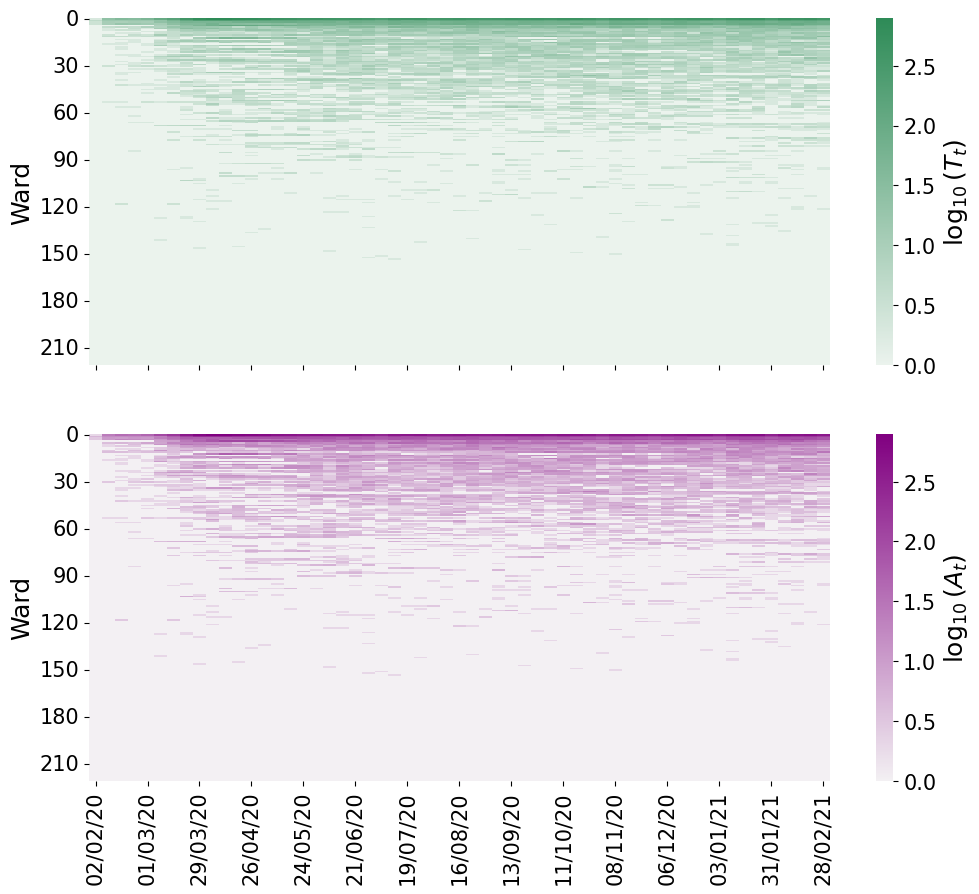

In [60]:
from utils_local import plot_utils
import matplotlib.pyplot as plt
import seaborn as sns

xx_ticks = ['02-Feb-20', '', '15-Mar-20', '', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '',
            '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']

fig, ax  = plt.subplots(2, 1, figsize=(10.5, 9.2), sharex=True, sharey=True)

g = sns.heatmap(ax=ax[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{10}(T_t)$"})
ax[0].set_xlabel(None)

g = sns.heatmap(ax=ax[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{10}(A_t)$"})
ax[0].set_ylabel("Ward")
ax[1].set_ylabel("Ward")
ax[1].set_xlabel(None)

g.set_xticks(g.get_xticks()[::2])

g.set_yticks(g.get_yticks()[::2])

#g.set_xticklabels(g.get_xticklabels()[::2])
#g.set(yticklabels=['0','','', r'$\vdots$','','','115','',r'$\vdots$','','','210'])
#g.set(yticklabels=['0','', r'$\vdots$','','115','',r'$\vdots$','','210'])
#g.set(xticklabels=xx_ticks)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

#path_to_save  = os.path.join(path_to_ms_figs, "heatmaps_test_admission.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


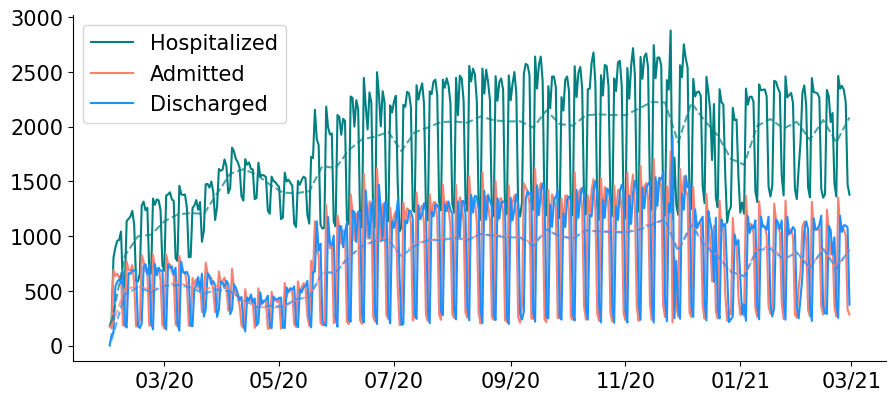

In [82]:
hosp_df = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).drop(columns=["ward"]).groupby(["date"]).sum()

COLOR_LIST1 = ["teal", "salmon", "dodgerblue"]

fig, ax = plt.subplots(1, 1, figsize=(10.5, 4.5))
ax.plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], label="Hospitalized")
ax.plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], label="Admitted")
ax.plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], label="Discharged")

hosp_df = hosp_df.resample("W-Sun").mean()
ax.plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], alpha=0.7, ls="--")
ax.plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], alpha=0.7, ls="--")
ax.plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], alpha=0.7, ls="--")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.tick_params(which='both', axis='x', labelrotation=0)

In [118]:
def create_obs_building_amro(amro, ward2building_dict, path_to_data, resample="W-Sun", p_oev=0.2):
    amro_df               = pd.read_csv(path_to_data, parse_dates=["date"]).drop(columns=["Unnamed: 0"])
    amro_df               = amro_df[amro_df["amro"]==amro]
    amro_df["buildingid"] = amro_df["ward_total"].map(ward2building_dict)
    amro_df               = amro_df.groupby(["date", "buildingid"]).sum(numeric_only=True).unstack([1]).resample(resample).sum(numeric_only=True).stack().reset_index()
    amro_df["obs_name"]   = amro_df["buildingid"]
    return amro_df

selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:

        return "Rest"

In [120]:
ward2building = {w: building2building(w.split("-")[1]) for w in ward_names}

path_to_amro  = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )
amro_search   = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                    'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                    "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

obs_df = create_obs_building_amro(amro_search[0], ward2building, path_to_amro)
obs_df

,date,buildingid,num_positives,obs_name
0,2020-02-02,Allen Hospital,0,Allen Hospital
1,2020-02-02,Harkness Pavilion,0,Harkness Pavilion
2,2020-02-02,Milstein Hospital,0,Milstein Hospital
3,2020-02-02,Mschony,1,Mschony
4,2020-02-02,Presbyterian Hospital,1,Presbyterian Hospital
...,...,...,...,...
337,2021-02-28,Harkness Pavilion,0,Harkness Pavilion
338,2021-02-28,Milstein Hospital,32,Milstein Hospital
339,2021-02-28,Mschony,4,Mschony
340,2021-02-28,Presbyterian Hospital,11,Presbyterian Hospital


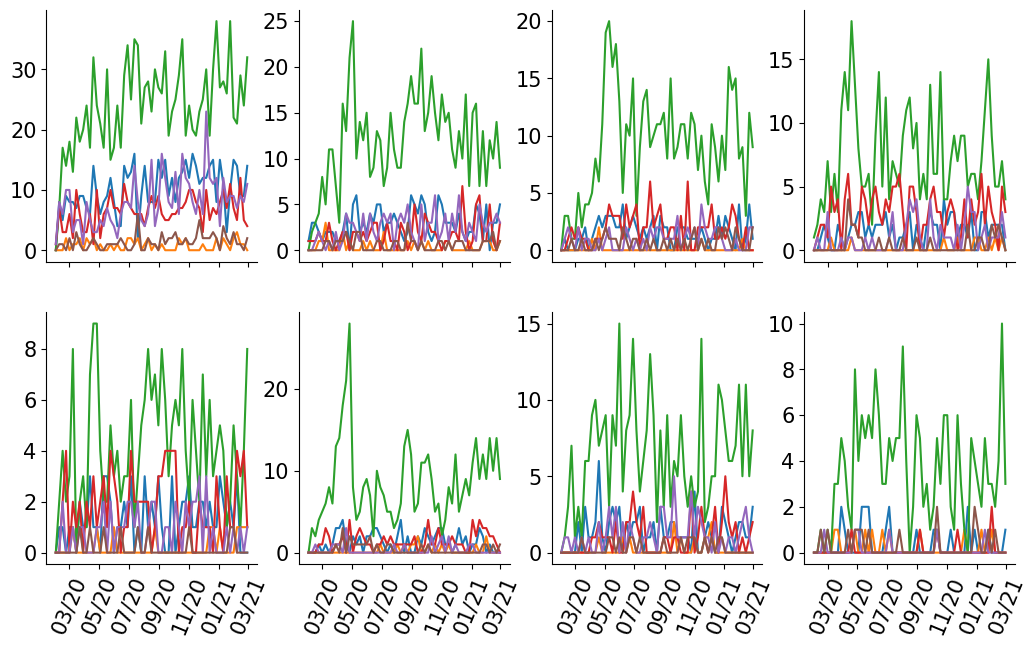

In [127]:
ward2building = {w: building2building(w.split("-")[1]) for w in ward_names}
fig, axes     = plt.subplots(2, 4, figsize=(12.5, 7.2), sharex=True, sharey=False)

for amro_id, amro in enumerate(amro_search):
    obs_df = create_obs_building_amro(amro, ward2building, path_to_amro)
    ax     = axes.flatten()[amro_id]

    sns.lineplot(ax=ax, data=obs_df, x="date", y="num_positives", hue="obs_name")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
gir
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.tick_params(which='both', axis='x', labelrotation=67.5)
